## About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

import pandas
import numpy

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

### Download data

In [4]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_train_10000.root' already there; not retrieving.


In [4]:
# you can download training sample with 100000 available events
# uncomment the below row
# !cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

In [5]:
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_test.root' already there; not retrieving.


### Read the smallest part of training file and test file

In [6]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

In [7]:
data.head()

,event_id,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1000001,1,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,...,0.877472,-0.256736,0.000000,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.685760
1,1000002,1,54.250927,-1.057915,2.310697,51.167873,2.545749,31.039040,-2.220276,-0.737298,...,-1.139118,-1.300325,2.000016,65.837746,201.096756,83.321556,208.039688,67.118484,287.363983,527.247559
2,1000003,1,47.746025,-0.783184,2.660325,68.165527,-1.700790,36.945312,-1.151738,-0.626912,...,-0.798898,-1.605550,2.000016,69.316925,156.334732,95.307602,149.089005,130.389206,237.879318,336.058838
3,1000004,0,45.950066,1.613817,0.964722,39.302082,-0.075989,84.307426,0.465748,2.287783,...,-0.586711,-2.256246,2.000023,71.032066,182.341537,81.941925,164.411148,93.709511,237.900055,392.807831
4,1000005,0,44.409187,-0.228907,-1.837974,49.886654,0.156533,32.852112,2.561646,2.641460,...,0.293522,1.391425,0.000000,122.030174,288.594086,84.386459,150.299744,69.818291,435.990356,533.977905


In [8]:
test.head()

,event_id,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,58.814354,-1.223199,1.290717,26.435696,2.608772,68.413330,0.639561,-1.226549,1.000008,...,-1.195189,1.767687,0.000000,72.190338,170.810608,78.644196,224.813538,95.737434,372.835388,469.654236
1,2,21.390781,-0.468277,-1.371404,57.185963,1.214130,118.127953,-0.113784,-2.182008,0.000000,...,0.965376,2.698023,1.000000,62.736309,215.426300,73.971413,211.729141,195.910385,310.480103,431.597137
2,3,58.570217,1.443092,0.105191,54.450954,-2.354347,26.443583,-1.911658,1.337635,0.000000,...,-2.212247,-2.609508,0.000000,48.172768,163.506821,106.111038,260.643646,351.328644,638.053040,790.960815
3,4,70.469345,0.166176,-1.962429,38.138966,2.564890,42.678413,-1.256608,-0.276156,2.000000,...,-0.007441,3.048725,2.000023,99.099815,158.532227,79.701500,169.550491,96.056900,305.073212,402.656067
4,5,113.456779,0.232503,2.941150,64.401146,1.125812,164.289139,-0.735258,-0.590741,1.999937,...,-0.943712,1.599526,2.000023,50.816051,200.099945,130.013855,187.637009,142.145920,433.032440,507.496399


### Define training features

Exclude `event_id`, `target` from the features set

In [7]:
features = list(set(data.columns) - {'event_id', 'target'})
features

['jet3_pt',
 'jet3_eta',
 'm_jjj',
 'mem_phi',
 'jet1_pt',
 'jet4_phi',
 'jet1_phi',
 'jet2_eta',
 'jet3_btag',
 'm_jlv',
 'm_wbb',
 'jet4_pt',
 'jet4_btag',
 'jet2_pt',
 'jet1_btag',
 'm_jj',
 'm_wwbb',
 'jet2_phi',
 'lepton_phi',
 'm_bb',
 'm_lv',
 'jet4_eta',
 'jet2_btag',
 'lepton_pt',
 'mem_pt',
 'lepton_eta',
 'jet3_phi',
 'jet1_eta']

### Prepare high-level features for training

In [8]:
high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
low_level_features = ['jet1_pt', 'jet1_btag', 'jet2_pt', 'jet2_btag', 'jet3_pt', 'jet3_btag', 'jet4_pt', 'jet4_btag',
                      'lepton_pt']
total_features = high_level_features + low_level_features

### Plot histograms for each high-level feature

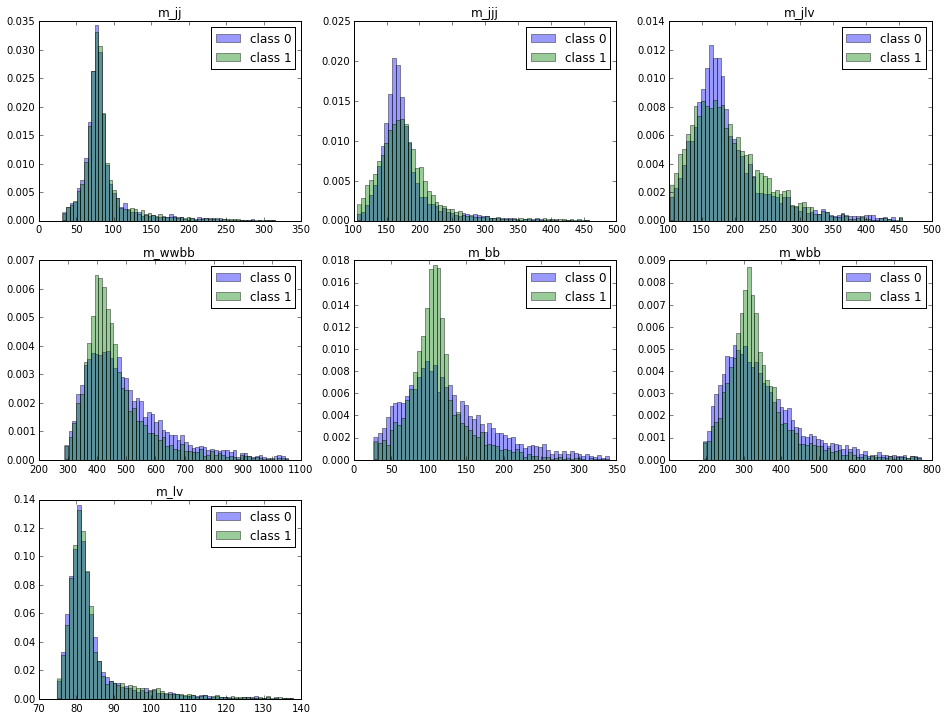

In [10]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(high_level_features):
    # add sub plot on our figure
    plt.subplot(len(features) // 5 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

### Divide training data into 2 parts 
`train_test_split` function is used to divide into 2 parts to preserve quality overestimating.

In [9]:
training_data, validation_data = train_test_split(data, random_state=70, train_size=0.75)

### Simple knn from `sklearn` training

In [13]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=26, weights='distance')
knn.fit(training_data[total_features], training_data.target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=26, p=2, weights='distance')

In [14]:
# predict validation sample (probability for each event)
proba = knn.predict_proba(validation_data[total_features])

In [15]:
proba

array([[ 0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667],
       [ 1.        ,  0.        ],
       ..., 
       [ 0.66666667,  0.33333333],
       [ 0.5       ,  0.5       ],
       [ 0.66666667,  0.33333333]])

### Compute quality (ROC AUC) on the validation set (to prevent overestimating quality)

In [15]:
# take probability to be 1 class to compute ROC AUC
roc_auc_score(validation_data.target, proba[:, 1])

0.75381715000240468

## Prepare submission to kaggle

In [16]:
# predict test sample
kaggle_proba = knn.predict_proba(test[total_features])[:, 1]
kaggle_ids = test.event_id

In [17]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)

/notebooks/higgs_kaggle/datasets/baseline.csv